In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from tqdm import tqdm_notebook

In [5]:
import sys
sys.path.append("../utils/")

In [6]:
import crispr_assembler as ca

In [418]:
class PCR:
    def __init__(self, population_as_list, n_primers, p = None, transform_to_min_range = 1, max_array_len = None):
        if transform_to_min_range:
            population_as_list = self._transform_to_min_range(population_as_list)
            
        if max_array_len is None:
            self.max_array_len = max([len(x) for x in population_as_list])
        else:
            self.max_array_len = max_array_len
        
        self.f_population = np.ones((len(population_as_list), self.max_array_len + 2)) * -1
        
        for i, array in enumerate(population_as_list):
            self.f_population[i][1:1 + len(array)] = np.array(array) + 1
        self.b_population = np.copy(self.f_population)
        
        self.n_f_primes = n_primers
        self.n_b_primers = n_primers
        self.initial_n_f = n_primers
        self.initial_n_b = n_primers
        
        self.n_spacers = len(set([x for y in population_as_list for x in y]))
        
        if p is None:
            self.p = [1 / self.max_array_len, 0.1 / self.max_array_len, 0]
            self.p[-1] = 1 - self.p[0] - self.p[1]

            self.initial_p = [x for x in self.p]
        else:
            self.p = [x for x in p]
            self.initial_p = [x for x in p]
        
        self.correct_pairs = set(self.to_pairs().keys())
        
    def _transform_to_min_range(self, population_as_list):
        spacers = set([sp for arr in population_as_list for sp in arr])
        spacers_list_sorted = sorted(list(spacers))
        translate_dict = dict(zip(spacers_list_sorted, np.arange(len(spacers)).astype(int)))
        population_transformed = [[translate_dict[sp] for sp in arr] for arr in population_as_list]
        
        return population_transformed
        
    def _increase_populations(self, n_f, n_b):
        self.f_population = np.vstack((self.f_population, np.zeros((n_f, self.max_array_len + 2))))
        self.b_population = np.vstack((self.b_population, np.zeros((n_b, self.max_array_len + 2))))
        
        self.n_f_primes -= n_f
        self.n_b_primers -= n_b
        
    def _make_annealing_masks(self, f_mask=None, b_mask=None):
        #print(self.b_population.size)
        if f_mask is None or b_mask is None:
            f_annealing_mask = np.random.choice([0,1,2], self.f_population.shape, p = self.p)#.reshape(self.f_population.shape)
            b_annealing_mask = np.random.choice([0,1,2], self.b_population.shape, p = self.p)#.reshape(self.b_population.shape)
        else:
            f_annealing_mask = f_mask
            b_annealing_mask = b_mask

        
        f_annealing_mask[self.f_population <= 0] = 2
        b_annealing_mask[self.b_population <= 0] = 2
        return f_annealing_mask, b_annealing_mask, (b_annealing_mask == 0).sum(), (f_annealing_mask == 0).sum()
    
        
    def _make_annealing_linkage(self, f_annealing_mask, b_annealing_mask):
        f_indeces_0 = np.vstack(np.where(f_annealing_mask == 0)).T
        nonzero_b = (self.b_population.sum(1) != 0).sum()
        b_paired_0 = np.vstack((np.arange(nonzero_b,
                                          nonzero_b + f_indeces_0.shape[0]),
                                np.ones(f_indeces_0.shape[0]) * (self.max_array_len + 2))).T
        
        #print(self.f_population.shape)
        b_indeces_0 = np.vstack(np.where(b_annealing_mask == 0)).T
        nonzero_f = (self.f_population.sum(1) != 0).sum()
        f_paired_0 = np.vstack((np.arange(nonzero_f,
                                          nonzero_f + b_indeces_0.shape[0]),
                                -np.ones(b_indeces_0.shape[0]))).T
        
        
        f_indeces_1 = np.vstack(np.where(f_annealing_mask == 1)).T
        b_indeces_1 = np.vstack(np.where(b_annealing_mask == 1)).T
        np.random.shuffle(f_indeces_1)
        np.random.shuffle(b_indeces_1)
        f_indeces_1 = f_indeces_1[:min(f_indeces_1.shape[0], b_indeces_1.shape[0])]
        b_indeces_1 = b_indeces_1[:min(f_indeces_1.shape[0], b_indeces_1.shape[0])]
        

        return np.vstack((f_indeces_0, f_paired_0, f_indeces_1)).astype(int), \
                np.vstack((b_paired_0, b_indeces_0, b_indeces_1)).astype(int)
#         return np.vstack((f_indeces_0, f_paired_0, f_indeces_1)).astype(int), \
#                 np.vstack((b_indeces_0, b_paired_0, b_indeces_1)).astype(int)
#         return np.vstack((f_paired_0,f_indeces_0,  f_indeces_1)).astype(int), \
#             np.vstack((b_paired_0,b_indeces_0,  b_indeces_1)).astype(int)


    def _debug_set_populations(self, fp, bp):
        self.f_population = fp
        self.b_population = bp 
        
        
    def _copy(self, index_f, index_b):
        if index_f[1] <= self.max_array_len and self.f_population[index_f[0], index_f[1] + 1] == 0:
            b_copy_part = self.b_population[index_b[0], index_b[1]:]
#             print(b_copy_part)
            copy_len = min(b_copy_part.shape[0], self.max_array_len + 1 - index_f[1])
            b_copy_part = b_copy_part[:copy_len]
            self.f_population[index_f[0], index_f[1] + 1 :index_f[1] + 1 + copy_len] = b_copy_part

        if index_b[1] > 0 and self.b_population[index_b[0], index_b[1] - 1] == 0:
            f_copy_part = self.f_population[index_f[0], : index_f[1] + 1]
#             print(f_copy_part)
            copy_len = min(f_copy_part.shape[0], index_b[1])
            
            f_copy_part = f_copy_part[-copy_len:]
#             print(f_copy_part, index_b[1] - copy_len, index_b[1])
            self.b_population[index_b[0], index_b[1] - copy_len : index_b[1]] = f_copy_part
    
    
    def _recalc_p(self):
        multiplicator = ((self.n_f_primes + self.n_b_primers) / (self.initial_n_f + self.initial_n_b))  ** 0.1
        self.p = [self.initial_p[0] * multiplicator, self.initial_p[1] / multiplicator, 0]
#         print("selfp", self.n_f_primes, self.p[0], multiplicator, multiplicator ** 0.1)
#         if self.p[0] < 0.01:
#             self.p[0] = self.initial_p[1]
#             self.p[1] = self.initial_p[0]
        self.p[2] = 1 - self.p[0] - self.p[1]
        
        
    def anneal(self):
        if self.n_f_primes > 0 and self.n_b_primers > 0:
            self._recalc_p()
            fm, bm, nf,nb = self._make_annealing_masks()
            #print(nf, nb)
            self._increase_populations(nf, nb)

            fi, bi = self._make_annealing_linkage(fm, bm)

            for i in range(len(fi)):
                self._copy(fi[i], bi[i])
                
            
        if (self.f_population.shape[0] > 100000) or (self.b_population.shape[0] > 100000): 
            print('ENTER population cut')
            print(calc_noise_ratio(gr0, self.to_graph()))
            
            f_mask = np.random.binomial(1, 0.5, self.f_population.shape[0]).astype(bool)
            b_mask = np.random.binomial(1, 0.5, self.b_population.shape[0]).astype(bool)
            
            self.f_population = self.f_population[f_mask]
            self.b_population = self.b_population[b_mask]
            
            
            print(self.f_population.shape[0], self.b_population.shape[0])
            print(calc_noise_ratio(gr0, self.to_graph()))
            
#             self.n_f_primes /= 2
#             self.n_b_primers /= 2
#             self.initial_n_f /= 2
#             self.initial_n_b /= 2
#             print('ENTER population cut', self.f_population.shape[0], self.b_population.shape[0])
#         else:
#             print('NO population cut', self.f_population.shape[0], self.b_population.shape[0])
        

    def to_pairs(self):
        all_pairs = {}
        for product in np.vstack((self.f_population,self.b_population)):
            for a,b in zip(product, product[1:]):
                if a!= -1 and a!= 0 and b!= -1 and b!=0:
                    if (a,b) in all_pairs:
                        all_pairs[(a,b)] += 1
                    else:
                        all_pairs[(a,b)] = 1
        return all_pairs
    
    def to_graph(self):
        gr = np.zeros((self.n_spacers, self.n_spacers))
        
        for p, n in self.to_pairs().items():
            if p[0] >= 0 and p[1] >= 0:
                gr[int(p[0]) - 1][int(p[1]) - 1] = n
        return gr

In [8]:
def pcr_cycles(population, cycles=35, p=[0.1, 0.01, 0.89], v=0):
    pcr = PCR(population, len(population) * 1000000, p = p)
    pop_size = []
    noise = []
    chimera = []
    
    gr0 = pcr.to_graph()
    
    for i in range(cycles):
        pcr.anneal()
        pop_size.append(pcr.f_population.shape[0] + pcr.b_population.shape[0])
        n,c = calc_noise_ratio(gr0, pcr.to_graph())
        noise.append(n)
        chimera.append(c)
        if v:
            print("Cycle:", i)
            print("Sizes:", pop_size[-1], pcr.n_f_primes, pcr.n_b_primers)
            print("Noise:", )
    
    gr = pcr.to_graph()
    
    return gr0, gr, pop_size, noise, chimera
        
    

In [415]:
# p_list_0 = [[1, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(50)] + \
#             [[4, 2, 5, 7, 11] for i in range(50)] + \
#                [[4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34] for i in range(10)] + \
#                [[1, 20, 22, 23, 21, 29] for i in range(10)]

In [416]:
p_true = [[2, 21, 18, 19, 22, 30, 27, 29, 28, 31, 33, 32, 34] for i in range(1)] + \
           [[0, 20, 24, 26, 23, 25] for i in range(1)] +\
           [[0, 1, 3, 6, 7, 10, 12, 15, 16, 14, 17, 13, 11] for i in range(1)] +\
           [[2, 4, 5, 9, 8] for i in range(1)]

In [417]:
p_list_0 = [[2, 21, 18, 19, 22, 30, 27, 29, 28, 31, 33, 32, 34] for i in range(2)] + \
           [[0, 20, 24, 26, 23, 25] for i in range(2)] +\
           [[0, 1, 3, 6, 7, 10, 12, 15, 16, 14, 17, 13, 11] for i in range(10)] +\
           [[2, 4, 5, 9, 8] for i in range(10)]

In [418]:
p_list_no0 = [[x+1 for x in y] for y in p_list_0]

In [424]:
#pcr = PCR(p_list_0, len(p_list_0) * 10000, p = [0.9, 0.0999999999, 0.0000000001])
pcr = PCR(p_list_0, len(p_list_0) * 1000000, p = [0.1, 0.01, 0.89])

[  3.57700000e+03   1.14130000e+04   1.36100000e+03   2.24030000e+04
   1.91400000e+03   2.21500000e+03   3.09130000e+04   3.86540000e+04
   6.70000000e+02   1.70000000e+03   4.47720000e+04   4.41900000e+03
   4.64540000e+04   1.18430000e+04   3.00080000e+04   4.45850000e+04
   3.78890000e+04   2.04090000e+04   6.35000000e+02   4.47000000e+02
   2.50000000e+01   4.37000000e+02   3.70000000e+02   1.24000000e+02
   2.70000000e+01   9.90000000e+01   8.80000000e+01   6.11000000e+02
   9.08000000e+02   7.73000000e+02   4.28000000e+02   9.18000000e+02
   5.57000000e+02   8.42000000e+02   1.62000000e+02]
[12 10 15  7 16  6 14  3 17 13  1 11  0  5  4  9  2 31 28 33 29  8 18 27 32
 19 21 30 22 34 23 25 26 24 20]


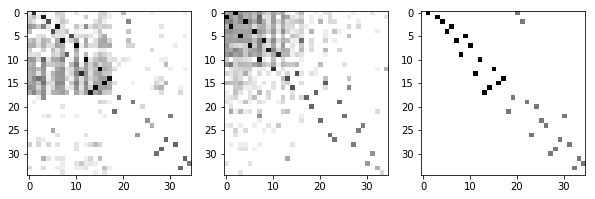

In [429]:
ca.plot_grs(gr,rearange(gr), gr0, log =1)

In [374]:
gr0 = pcr.to_graph()

In [375]:
size = []

In [388]:
for i in range(5):
    pcr.anneal()
    size.append(pcr.f_population.shape[0])
#     print(pcr.f_population.shape[0], pcr.b_population.shape[0])
#     print(pcr.n_f_primes)
#     print(pcr.p)
#     print('11 sum', pcr.to_graph()[11].sum())

67343 67649
1432525.75
[0.099646936180339818, 0.010035431477694529, 0.8903176323419657]
11 sum 1161.0
87001 87595
1412867.75
[0.099540674384661451, 0.010046144515111839, 0.89041318110022671]
11 sum 1543.0
56102 56316
693636.375
[0.099402212739595111, 0.010060138224686297, 0.89053764903571853]
11 sum 1051.0
72607 72801
677131.375
[0.099220901534144104, 0.010078521607222829, 0.89070057685863313]
11 sum 1432.0
93680 93885
656058.375
[0.098982364280933682, 0.010102809801165999, 0.89091482591790039]
11 sum 1917.0


In [389]:
gr = pcr.to_graph()

In [413]:
calc_noise_ratio(gr0, gr)

(0.99313464178983923, 0.063673469387755102)

In [367]:
def get_weights(gr, arrays):
    weights = []
    for a in arrays:
        w = []
        for x, y in zip(a, a[1:]):
            w.append(gr[x, y])
        weights.append(w)
    
    return weights

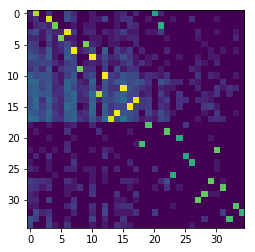

In [361]:
plt.imshow(np.log(gr + 1))
plt.show()

In [355]:
np.arange(gr.shape[0])[::-1]

array([34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18,
       17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,
        0])

[ 10382.  26030.   4168.  38301.   7385.   8108.  48973.  57265.   3387.
   7410.  62792.  10691.  65024.  27804.  51071.  63763.  58991.  40471.
   3390.   4299.   1188.   2236.   5009.   1246.   1502.    564.   1483.
   5606.   5058.   5399.   5482.   4435.   2273.   3418.    878.]
[12 15 10 16  7 14  6 17  3 13  1 11  0  5  9  4 27 30 29 28 22 31 19  2 33
 18  8 32 21 24 26 23 20 34 25]


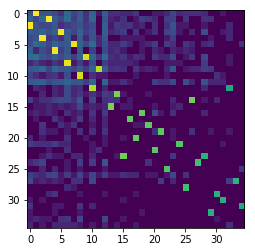

In [359]:
plt.imshow(np.log(rearange(gr) + 1))
plt.show()

In [84]:
def calc_noise_ratio(gr0, gr):
    return 1 - gr[gr0>0].sum() / gr.sum(), ((gr > 0).sum() - (gr0 > 0).sum()) / gr.flatten().shape[0]

In [22]:
answ = [[2, 21, 18, 19, 22, 30, 27, 29, 28, 31, 33, 32, 34], \
        [0, 20, 24, 26, 23, 25], \
        [0, 1, 3, 6, 7, 10, 12, 15, 16, 14, 17, 13, 11],\
        [2, 4, 5, 9, 8]]

In [10]:
import sys

In [11]:
sys.path.append("../")
import utils.plot_utils as pu

In [444]:
import pickle

In [445]:
db = pickle.load(open("../../db_as_clusters", 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '../../db_as_clusters'

In [12]:
def gen_initial_p(db, max_arr, max_per_array):
    n = len(db)
    n_arr = np.random.randint(0, max_arr)
    population = []
    for i in range(n_arr):
        n_repetitions = np.random.randint(1,max_per_array)
        arr = np.random.choice(db)
        if len(arr) > 1:
            population.extend([arr for j in range(n_repetitions)])
    
    return population

In [13]:
def population_to_pairs(pop, sp_to_n):
    pairs = {}
    for arr in pop:
        for a, b in zip(arr, arr[1:]):
            key = (sp_to_n[a], sp_to_n[b])
            if key in pairs.keys():
                pairs[key] +=1
            else:
                pairs[key] = 1
    return pairs

In [14]:
def to_graph(pairs, n):
    gr = np.zeros((n, n))

    for p, n in pairs.items():
        if p[0] >= 0 and p[1] >= 0:
            gr[int(p[0]) -1 ][int(p[1])-1] = n
    return gr

# SIMULATIONS THEMSELVES

In [477]:
def generate_initial_population(spacers_num, chain_number=2, max_amount_per_chain = 2, min_len = 4, v = False):
    # markov is our god! 
    graph = np.zeros((spacers_num, spacers_num))
    for i in range(spacers_num):
        for j in range(spacers_num - 1, i, -1):
            graph[i,j] = spacers_num - j + i

    if v:
        ca.plot_gr(graph)
        plt.imshow(graph)
        plt.show()
        
    graph /= np.max(np.vstack((graph.sum(1), np.ones(spacers_num))), 0).reshape(-1,1)
    
    all_chains = []
    while len(all_chains) < chain_number:
        chain = []
        amount = np.random.randint(1, max_amount_per_chain)
        max_len = max([np.random.randint(min_len,spacers_num + 1) for i in range(3)])
        curr = np.random.randint(0, max((spacers_num - 1) / 2, 1))#, spacers_num - 10))

        for j in range(max_len):
            chain.append(curr)
            if curr != spacers_num - 1:
                #print(np.arange(spacers_num), graph[curr])
                if v:
                    print(curr, graph[curr])
                curr = np.random.choice(np.arange(spacers_num), 1, p = graph[curr])[0]
            else:
                break
        
        if len(chain) > min_len:
            all_chains.extend([chain for k in range(amount)])
        if v:
            print('____')
    
    return all_chains[:chain_number]

In [210]:
def generate_initial_population_2(chain_number=2,
                                  max_chain_replications = 2,
                                  min_len = 4,
                                  max_len = 15,
                                  p_adoption = 0.3,
                                  p_cross = 0.1,
                                  p_tree = 0.1,
                                  v = False):
    curr = 0
    
    chains_num = np.random.randint(1, chain_number + 1)
    chains_single = []
    
    for i in range(chains_num):
        chain = np.arange(curr, curr + np.random.randint(min_len, max_len)) 
        curr = chain[-1] + 1
        chains_single.append(chain)
        
    if v: print("CURR ", curr)
        
    chains_specific = []
    for chain in chains_single:
        if np.random.random() < p_adoption:
            adoption_part = np.arange(curr, curr + np.random.randint(0, 4))

            if len(adoption_part) > 0:
                curr = adoption_part[-1] + 1

            pos = np.random.randint(0, len(chain))

            new_chain = []
            new_chain.extend(chain[: pos])
            new_chain.extend(adoption_part)
            new_chain.extend(chain[pos:])
            
            chains_specific.append(np.array(new_chain))    
            
            if v: print("added specific: ", new_chain)
                
    chains_single.extend(chains_specific)
    
    if v: print("CURR ", curr)
        
    chains_cross = []
    for chain in chains_single:
        if np.random.random() < p_cross:
            chain_position = np.random.randint(0, len(chain))
            
            cross_chain = [x for x in range(curr, curr + np.random.randint(4, 15))]
            cross_chain_position = np.random.randint(0, len(cross_chain))
            
            new_cross_chain = cross_chain[:cross_chain_position] + \
                                [chain[chain_position]] + \
                                cross_chain[cross_chain_position:]
            chains_cross.append(new_cross_chain)
            
            curr = cross_chain[-1] + 1
            
            if v: print("added cross: ", new_cross_chain)
    chains_single.extend(chains_cross)
    
    if v: print("CURR ", curr)
    
    chains_tree = []
    chains_tree_number = int(len(chains_single) * p_tree)
    for i in range(chains_tree_number):
        chain = np.random.choice(chains_single, 1)[0]
        
        chain_position = np.random.randint(0, len(chain))
        tree_chain = [x for x in range(curr, curr + np.random.randint(1, 5))]
        
        chains_tree.append(list(chain[:chain_position]) + tree_chain)
        curr = tree_chain[-1] + 1
        if v: print("added tree: ", chain, chain_position, list(chain[:chain_position]) + tree_chain)
    
    chains_single.extend(chains_tree)
    
    if v: print("CURR ", curr)   
    
    chains = []
    
    for chain in chains_single:
        replications = np.random.randint(1, max_chain_replications + 1)
        chains.extend([chain for i in range(replications)])
    
    return chains

In [216]:
generate_initial_population_2(50, 1, p_adoption = 0.5,p_cross=0.5,p_tree=0.5, v=0)

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]),
 array([35, 36, 37, 38, 39, 40, 41]),
 array([42, 43, 44, 45, 46, 47, 48, 49]),
 array([50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60]),
 array([61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]),
 array([73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]),
 array([86, 87, 88, 89, 90]),
 array([ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
 array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]),
 array([114, 115, 116, 117, 118]),
 array([119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131]),
 array([132, 133, 134, 135, 136, 137, 138]),
 array([139, 140, 141, 142, 143, 144]),
 array([145, 146, 147, 148, 149, 150, 151, 152]),
 array([153, 154, 155, 156, 157, 158, 159]),
 array([160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170]),
 array([171, 172, 173, 174, 175, 176, 177]),
 array([178

In [15]:
def shift_population(population):
    unique_sorted = sorted(list(set(ca.unwrap_nested(population))))
    new_ids = dict(zip(unique_sorted, np.arange(len(unique_sorted))))
    
    return [[new_ids[x] for x in y] for y in population]
    

In [275]:
def rearange(gr, order = None):
    new_gr = np.zeros_like(gr)
    
    #sums = np.arange(gr.shape[0])[::-1]
    if order is None:
        sums = gr.sum(0) + gr.sum(1)
        #print(sums)
        order = np.argsort(sums)[::-1]
        #print(order)
    
    for i in range(gr.shape[0]):
        for j in range(gr.shape[1]):
            new_gr[i,j] = gr[order[i], order[j]]
        
    return new_gr, order
    
    

In [16]:
initial_pops = []
pcrs = []

In [17]:
from multiprocessing import Pool

In [18]:
ps = []
for i in range(1000):
    p0 = 0.09 + np.random.random() / 50
    p1 = 0.01 + np.random.random() / 50
    p2 = 1 - p0 - p1
    p = [p0, p1, p2]
    ps.append(p)

In [19]:
np.mean([x[1] for x in ps])

0.020124662265467386

In [412]:
def amplify(pop, p0 = 0.1, p1=0.1, cycles = 20, return_history = 0, v=0):
    ratios = []
    ratios_unique = []
   
    
    if len(pop) > 0:
        p0 = p0 + np.random.random() / 50
        p1 = p1 + np.random.random() / 50
        p2 = 1 - p0 - p1
        p = [p0, p1, p2]
        
        pcr = PCR(pop, len(pop) * 100000, p = p) #[0.1, 0.01, 0.89]
        
        gr0 = pcr.to_graph()
        graphs = np.zeros((cycles, gr0.shape[0], gr0.shape[1]))
        
        for i in range(cycles):
            pcr.anneal()
            if return_history:
                gr = pcr.to_graph()
                r, r_u = calc_noise_ratio(gr0, gr)
                ratios.append(r)
                ratios_unique.append(r_u)
                graphs[i] = gr
            if v:
                print(pcr.f_population.shape[0], pcr.p, pcr.n_f_primes, calc_noise_ratio(gr0, gr))
                
                
        gr = pcr.to_graph()
        
    
    if return_history:
        return gr0, gr, ratios, ratios_unique, graphs
    else:
        return gr0, gr
    


In [310]:
def f(pop):
    
    if len(pop) > 0:
        p0 = 0.2 + np.random.random() / 50
        p1 = 0.1 + np.random.random() / 50
        p2 = 1 - p0 - p1
        p = [p0, p1, p2]
        
        pcr = PCR(pop, len(pop) * 100000, p = p) #[0.1, 0.01, 0.89]
        
        gr0 = pcr.to_graph()
        
        for i in range(30):
            pcr.anneal()

        gr = pcr.to_graph()
    
    
    return gr0, gr
    


In [308]:
initial_pops = []
while len(initial_pops) < 32:
    pop = generate_initial_population_2(50, 3, p_adoption = 0.2, p_cross=0.2, p_tree=0.2, v=0)
    if len(pop) > 0:
        initial_pops.append(pop)

In [309]:
len(initial_pops)

32

In [28]:
p.close()

In [225]:
p = Pool(32)

In [311]:
gr_list = p.map(f, initial_pops)

In [376]:
target_pop = initial_pops[1]

In [377]:
len(target_pop)

80

In [ ]:
gr0, gr, ratios, ratios_unique, graphs = amplify(target_pop, 0.2, 0.2, cycles = 20, return_history=1, v=1)

228 [0.21317349509942152, 0.21515105732557308, 0.5716754475750054] 7999852 (0.0, 0.0)
499 [0.21317310605459791, 0.21515144998019398, 0.57167544396520809] 7999581 (0.0, 0.0)
1077 [0.21317235192896763, 0.21515221110714761, 0.57167543696388479] 7999003 (0.0059909524391734692, 0.00059488399762046404)
2221 [0.21317075166413207, 0.21515382624672486, 0.57167542208914301] 7997859 (0.023015408621025912, 0.0035328825164807147)
4274 [0.21316776936673698, 0.21515683632980387, 0.57167539430345915] 7995806 (0.044470450555880614, 0.010222292367274096)
8238 [0.21316221953507686, 0.21516243809274649, 0.57167534237217665] 7991842 (0.070825649028230964, 0.0248151610435965)
16196 [0.21315148670504772, 0.21517327218033558, 0.57167524111461676] 7983884 (0.099822174802169483, 0.054777889740072118)
31619 [0.21313064846403817, 0.21519431013305057, 0.57167504140291125] 7968461 (0.12801689460981491, 0.10704269810244145)
62357 [0.21308942899388844, 0.21523593676598496, 0.57167463424012654] 7937723 (0.155137497901

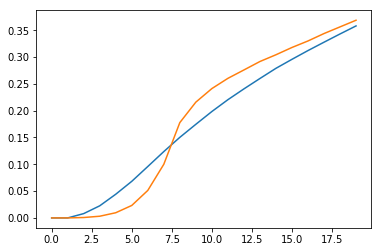

In [417]:
plt.plot(ratios)
plt.plot(ratios_unique)
plt.show()

In [387]:
graphs[:, 0, 0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [409]:
_, order = rearange(graphs[-1,:,:])

In [410]:
graphs[:, order, :][:,:,order][:, 0, 1]

array([  1.60000000e+01,   4.20000000e+01,   1.01000000e+02,
         2.26000000e+02,   4.85000000e+02,   1.02100000e+03,
         2.22400000e+03,   4.73200000e+03,   1.00030000e+04,
         1.07180000e+04,   1.14530000e+04,   1.24100000e+04,
         1.34340000e+04,   1.42450000e+04,   1.52500000e+04,
         1.62480000e+04,   1.75290000e+04,   1.88090000e+04,
         2.01230000e+04,   2.17450000e+04])

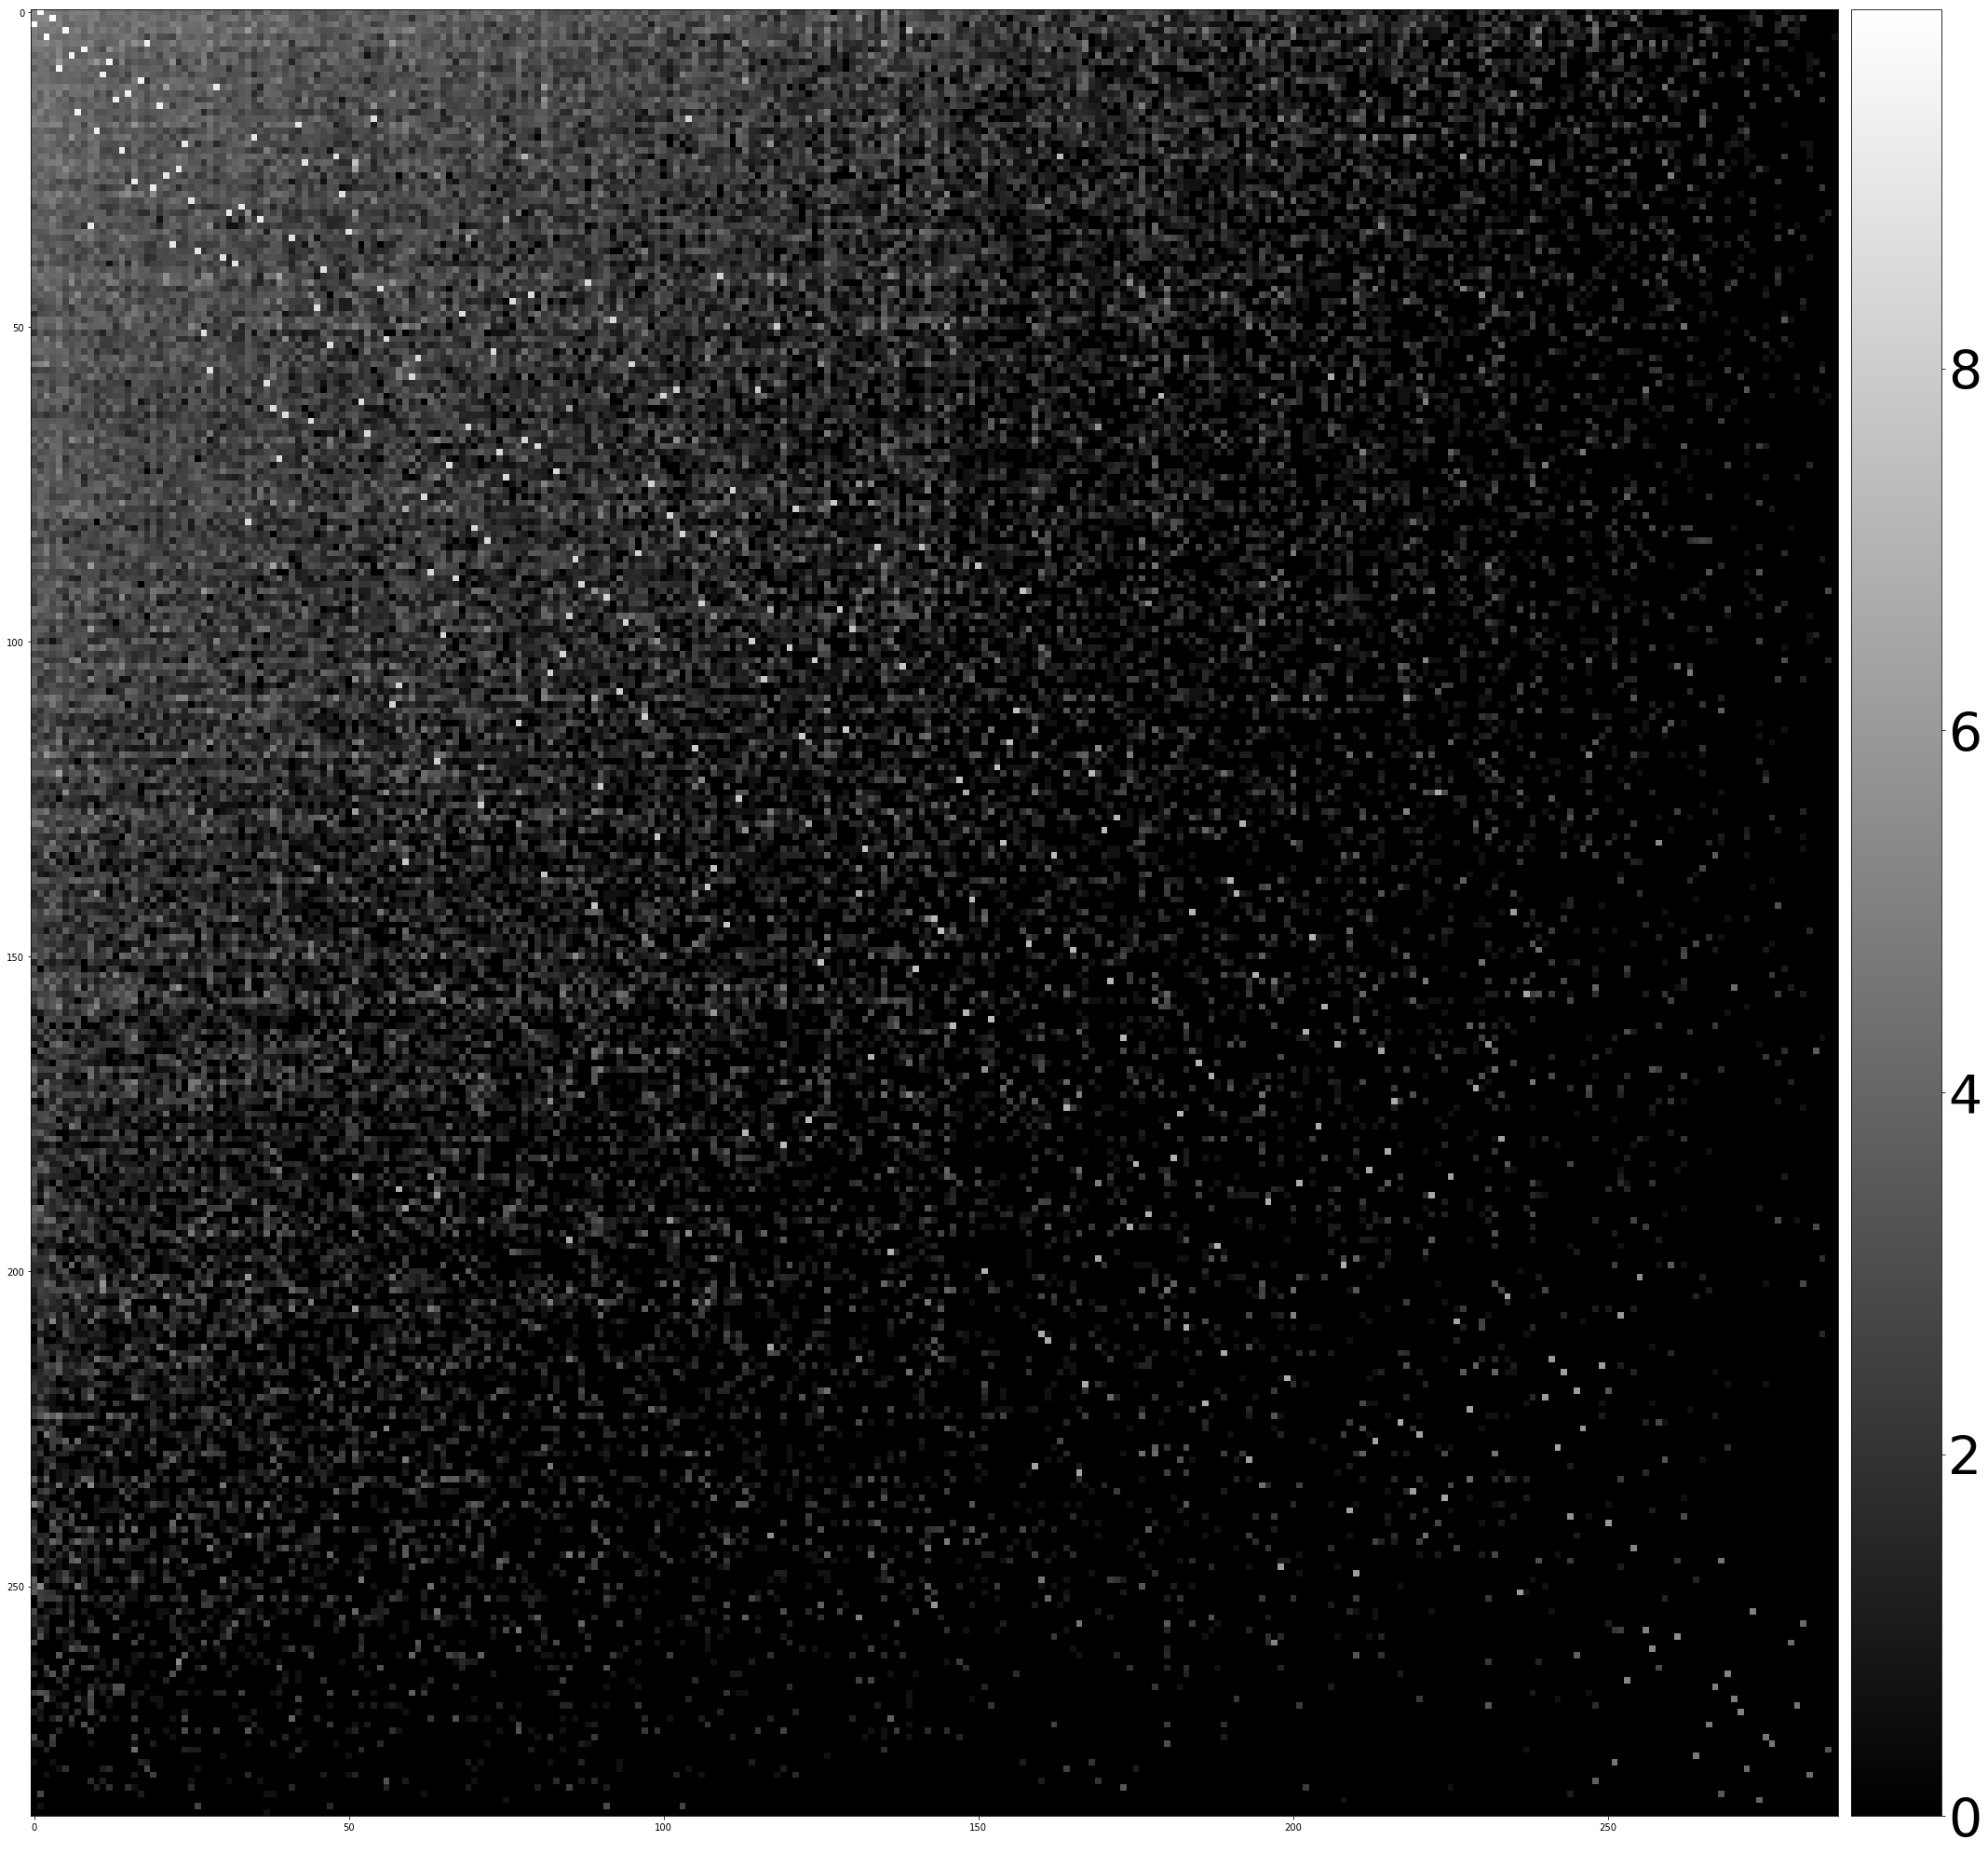

In [411]:
ca.plot_gr(graphs[-1][order][:, order], log =1)
plt.show()

In [408]:
calc_noise_ratio(gr0, gr)

(0.36099309095158472, 0.43581930095060034)

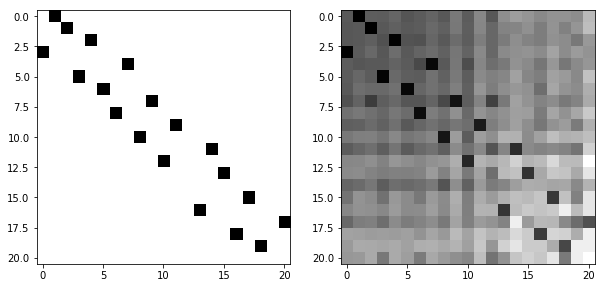

In [347]:
idx = 0
# ampl_gr, order = rearange(gr_list[idx][1])
# answ_gr, order = rearange(gr_list[idx][0], order)
ampl_gr, order = rearange(gr)
answ_gr, order = rearange(gr0, order)
ca.plot_grs(answ_gr, ampl_gr, log = 1)
plt.show()

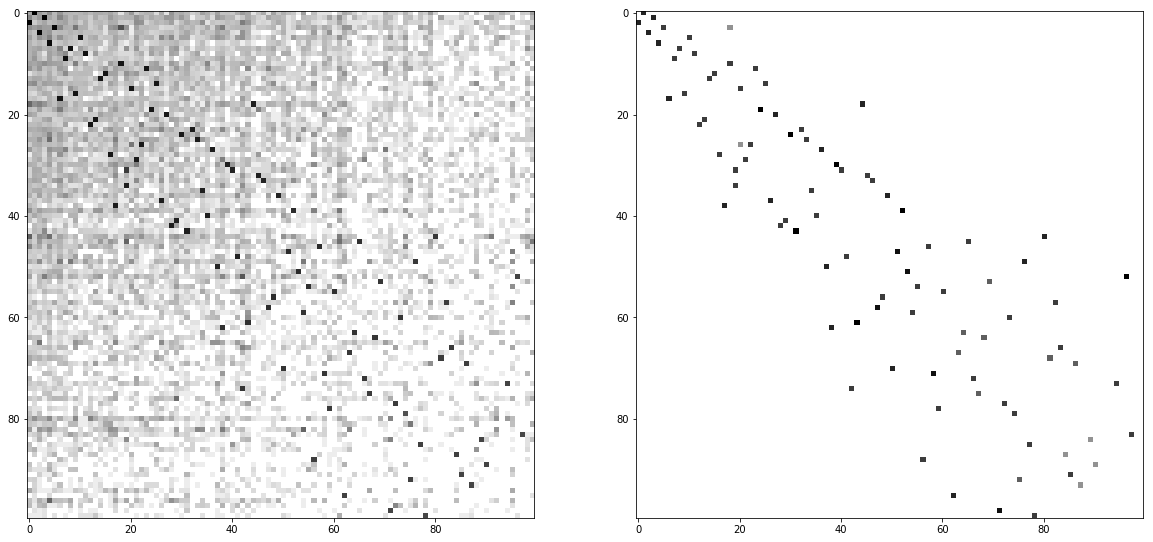

In [318]:
cut = 100
ca.plot_grs(ampl_gr[:cut, :cut],answ_gr[:cut, :cut], s = 20, log = 1)
plt.show()

In [314]:
def calc_noise_ratio(gr0, gr):
    return 1 - gr[gr0>0].sum() / gr.sum(), ((gr > 0).sum() - (gr0 > 0).sum()) / gr.flatten().shape[0]

In [348]:
calc_noise_ratio(answ_gr, ampl_gr)

(0.24703432676487069, 0.95238095238095233)

In [305]:
def get_top_stats(graph, i, cut=10, axis=0):
    return np.array(sorted(graph[i])[::-1][:10]), np.argsort(graph[i])[::-1][:10]

In [350]:
get_top_stats(ampl_gr, 0)

(array([ 48632.,   1302.,   1226.,   1157.,   1053.,   1012.,    978.,
           976.,    940.,    688.]),
 array([ 1,  5, 12,  8,  0,  6, 10,  3,  2,  7]))

In [111]:
ratio = []
single_ratio = []
for agr, amplgr in gr_list:
    x, y = calc_noise_ratio(agr, amplgr)
    ratio.append(x)
    single_ratio.append(y)

In [112]:
_1

(array([   3.,   32.,   73.,   91.,  100.,  104.,  133.,  129.,  122.,
          92.,   58.,   26.,   13.,    6.,    9.,    3.,    2.,    1.,
           2.,    1.]),
 array([ 0.06242796,  0.07493061,  0.08743325,  0.0999359 ,  0.11243855,
         0.12494119,  0.13744384,  0.14994648,  0.16244913,  0.17495178,
         0.18745442,  0.19995707,  0.21245971,  0.22496236,  0.237465  ,
         0.24996765,  0.2624703 ,  0.27497294,  0.28747559,  0.29997823,
         0.31248088]),
 <a list of 20 Patch objects>)

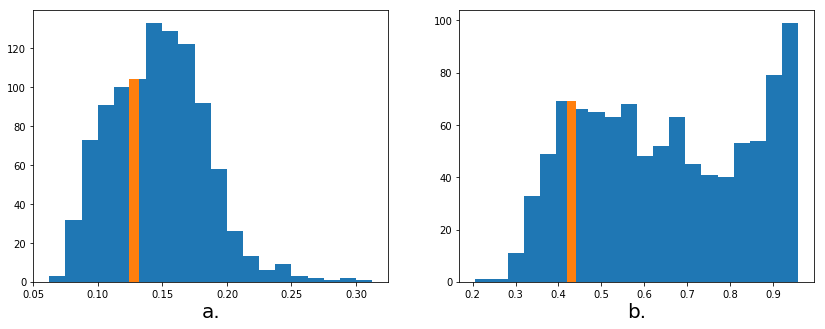

In [134]:
f = plt.figure(figsize=(14,5))

ax1, ax2 = f.subplots(1, 2)

_1 = ax1.hist(ratio, bins = 20)
ax1.hist([0.128]  *104, bins = [0.124,0.132])
ax1.set_xlabel("a.", fontsize = 20)


_2 = ax2.hist(single_ratio, bins = 20)
ax2.hist([0.43] * 69, bins = [0.419, 0.441])
ax2.set_xlabel("b.", fontsize = 20)

plt.show()

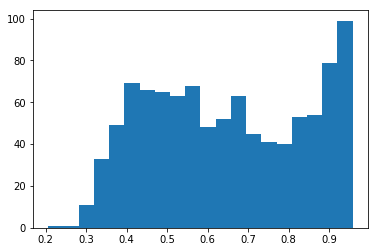

In [126]:
_ = plt.hist(single_ratio, bins = 20)
plt.show()

In [47]:
!ls

PCR_modeler.py					     amplifier_repeats.ipynb
PM, new annealing.ipynb				     data_gen-MP.ipynb
Stats.ipynb					     data_gen.ipynb
Untitled.ipynb					     default.ipynb
amplifier_repeats-each-to-each-grouped matrix.ipynb  default_ver2.ipynb
amplifier_repeats-each-to-each-lists-based.ipynb     default_ver3.ipynb
amplifier_repeats-each-to-each.ipynb		     pre package PCR.ipynb


In [48]:
for i, grs in enumerate(gr_list):
    np.save("../../data/simulation/repeat_to_repeat_1000/before/" + str(i), grs[0])
    np.save("../../data/simulation/repeat_to_repeat_1000/after/" + str(i), grs[1])

In [46]:
for i in tqdm_notebook(range(20)):
    gr_list_ = p.map(f, initial_pops[i*50: (i+1)*50])
    gr_list.extend(gr_list_)

A Jupyter Widget

In [32]:
len(gr_list)

1000

In [42]:
pickle.dump(gr_list, open("../../data/simulation/5_20_01_005/gr_list_1000", 'wb'))

In [43]:
pickle.dump([x[0] for x in gr_list], open('../../data/simulation/5_20_01_005/before_grs', 'wb'))
pickle.dump([x[1] for x in gr_list], open('../../data/simulation/5_20_01_005/after_grs', 'wb'))

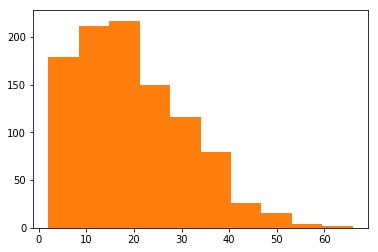

In [41]:
plt.hist([x[0].shape[0] for x in gr_list])
plt.show()

In [ ]:
np.random.set_state()

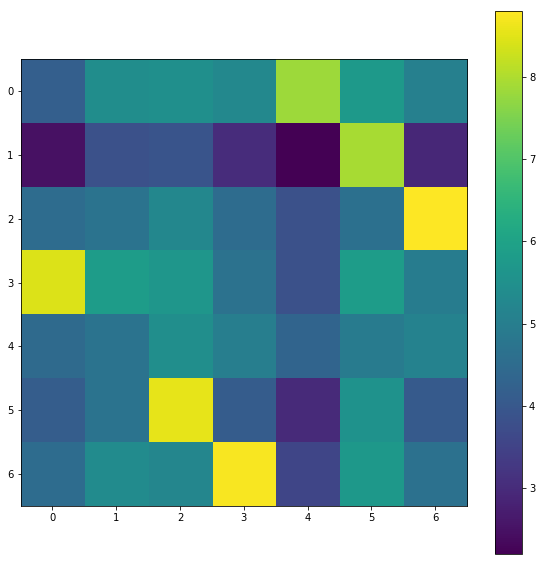

In [36]:
pu.plot_gr(gr_list[-4][1], log = 1)

In [ ]:
print(322)

In [ ]:
p.close()

In [240]:
before_grs = []
after_grs = []

In [251]:

for i in tqdm_notebook(range(1000)):
    pop = gen_initial_p(db, 40, 40)
    
    if len(pop) > 0:
        pcr = PCR(pop, len(pop) * 100000, p = [0.1, 0.05, 0.85])
        
        before_grs.append(pcr.to_graph())
        for i in range(20):
            pcr.anneal()

        after_grs.append(pcr.to_graph())

A Jupyter Widget

KeyboardInterrupt: 

In [242]:
import pickle

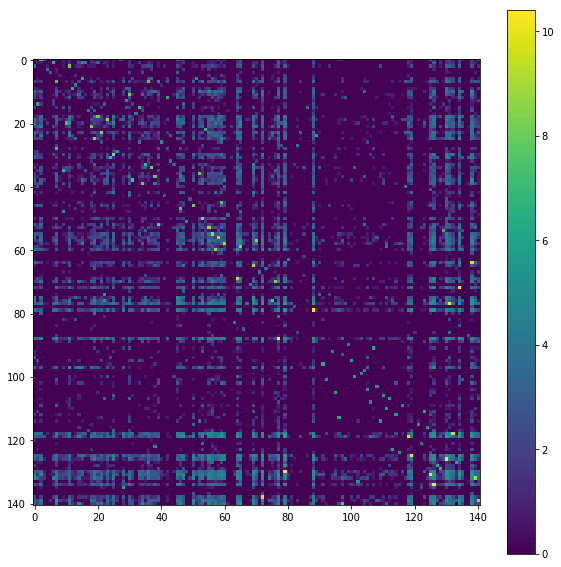

In [238]:
pu.plot_gr(after_grs[0], log = 1)


In [239]:
calc_noise_ratio(before_grs[0], after_grs[0])

0.82252584307066412

In [166]:
len(pcrs) == len(initial_pops)

True

In [167]:
before_grs = []
after_grs = []

In [168]:
for pcr, pop in tqdm_notebook(zip(pcrs, initial_pops)):
    all_spacers = set([x for y in pop for x in y])
    sp_to_n = dict(zip(all_spacers, np.arange(len(all_spacers)).astype(int)))
    
    pairs = pcr.to_pairs()
    new_pairs = {}

    for key in pairs.keys():
        new_key = (sp_to_n[key[0].astype(int)],sp_to_n[key[1].astype(int)])
        new_pairs[new_key] = pairs[key] 
        
    initial_pairs = population_to_pairs(pop, sp_to_n)
    
    before_grs.append(to_graph(initial_pairs, len(all_spacers)))
    after_grs.append(to_graph(new_pairs, len(all_spacers)))

A Jupyter Widget

KeyError: 20

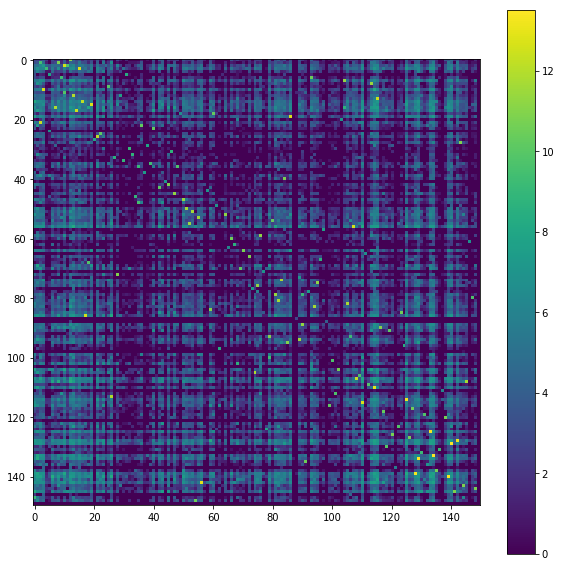

In [173]:
pu.plot_gr(after_grs[0], log = 1)